In [0]:

!pip install pytorch-pretrained-bert pytorch-nlp
!pip install transformers
! pip install seqeval[gpu]

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from sklearn.preprocessing import LabelEncoder
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found') 

torch.cuda.empty_cache()
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# **Importing necessary Libraries**

In [0]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import seaborn as sns
import os
from pytorch_pretrained_bert import BertTokenizer, BertConfig
import torch
from torch.optim import Adam
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


 Uploading Dataset and Pretrained Model

In [0]:
#Initial Variables and switches for the flow of execution.
bWindows10 = True
bcolab=False
filePath ="" #add full path if the file resides in a location other than this notebook's loaction add slash at the end or //
filename ="/content/Genia_all.csv"
#model specific
pretrained_model = "monologg/biobert_v1.0_pubmed_pmc"
saved_model ="monologg/biobert_v1.0_pubmed_pmc"
batch_size = 8 #keep this low to avoid CUDA errors
epochs = 1 #training epochs
bTraining = False
finalAccuracy = ''
bServ = True
bTestBMS=True

In [0]:
#Reading the csv file
df = pd.read_csv(filePath + filename)

Dropping Null Values

In [0]:
df.dropna(inplace=True)
from tqdm import tqdm, trange

Saving Sentences in List format 

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Tok"].values.tolist(),
                                                           s["POS_Tag"].values.tolist(),
                                                           s["NE_Tag"].values.tolist())]
        self.grouped = self.data.groupby(" Sent").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(df)

In [0]:
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[1]

'Activation of the CD28 surface receptor provides a major costimulatory signal for T cell activation resulting in enhanced production of interleukin-2 ( IL-2 ) and cell proliferation .'

Saving Corresponding NE_Tags in a list named labels

In [0]:
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[0])

['B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O']


Created List with encoding ID for each Tags 

In [0]:
tags_vals = list(set(df["NE_Tag"].values))
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [0]:
# Maxlen specifies the maximum number of words to consider. BERT can handle a maximum length of 512 
# but lesser is better to reduce memory and imporve speed.
MAX_LEN =  75
bs = 8

In [0]:
from transformers import BertTokenizer,BertForTokenClassification, BertForSequenceClassification

# Loading the BERT tokenizer.
print('Load BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(saved_model, do_lower_case=True)
print('Done')

Load BERT tokenizer...



Done


In [0]:
torch.cuda.empty_cache()
# Loading BertForTokenClassification, the pretrained BERT model with a single 
# linear classification layer on top.
model = BertForTokenClassification.from_pretrained(
    saved_model,num_labels=len(tag2idx))
# Telling pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print('Sentences :', sentences[0])
print('Tokenized Sentences :',tokenized_texts[0])

Sentences : IL-2 gene expression and NF-kappa B activation through CD28 requires reactive oxygen production by 5-lipoxygenase .
Tokenized Sentences : ['il', '-', '2', 'gene', 'expression', 'and', 'n', '##f', '-', 'ka', '##ppa', 'b', 'activation', 'through', 'c', '##d', '##28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5', '-', 'lip', '##ox', '##y', '##gen', '##ase', '.']


In [0]:
# Chosen maxlen = 75, using pad_sequencing to pad our input tokens with value 0 and "post" indicates
# that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [0]:
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)


Padding/truncating all sentences to 75 values...


In [0]:
# Creating attention masks, we create the mask to ignore the padded elements in the sequences
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Since using pytorch, we convert the dataset to torch tensors (necessary datatype to train BERT model).
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
#creating the dataloader for training set. Shuffling the data at training time with random sampler
# and at test times we just pass them sequentially with sequential sampler

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
## Using Adam optimizer for fine tunning of model
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [0]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime
from scipy.stats import chisquare
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [0]:
## Setting Epoch number and maximum gradient norm to help prevent the "exploding gradients" problem
epochs = 25
max_grad_norm = 1.0
## Creating Empty list for storing necessary model results
loss_val=[]
Valid_accu=[]

## Looping for training model in each loop
for _ in trange(epochs, desc="Epoch"):
  ## For calculating time per epoch and total time
    t0 = time.time()
    # Training 
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
      # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculating elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Reporting progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        
        ## Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()

        # adding batch to gpu

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # forward pass
        output = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        
        loss= output[0]

        # backward pass
        loss.backward()

        # track train loss
        tr_loss += loss.item()
        
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # updating parameters
        optimizer.step()
        
    # Calculating the average loss over the training data.
    avg_train_loss = tr_loss / len(train_dataloader)            
    
    # Storing the loss and accuracy value for plotting the learning curve.
    loss_val.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            #tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  #attention_mask=b_input_mask, labels=b_labels)
            outputs = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = outputs[0]
        #tmp_eval_loss=tmp_eval_loss[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculating the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        # Accumulating the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Tracking the number of batches
        nb_eval_steps += 1
        
        

        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    
    Valid_accu.append(eval_accuracy/nb_eval_steps)
    
    
    
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
    #print("Chisquare-Score: {}".format(chisquare(pred_tags, valid_tags)))

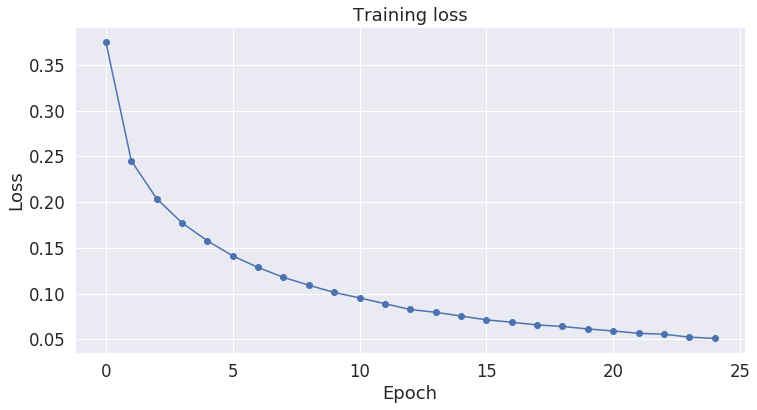

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_val, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

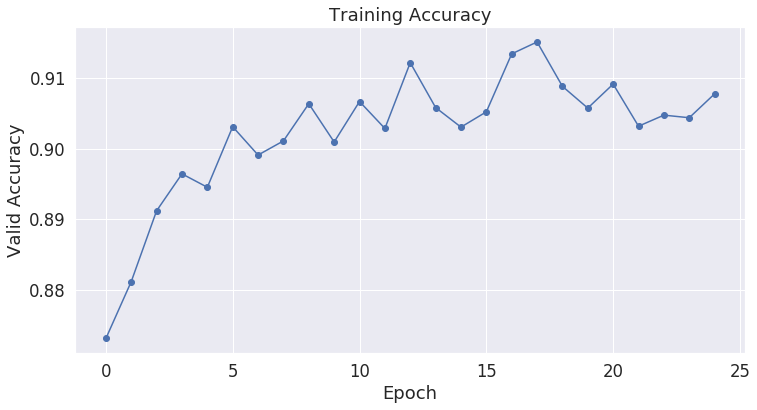

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(Valid_accu, 'b-o')

# Label the plot.
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Valid Accuracy")

plt.show()

In [0]:
Accuracy= pd.DataFrame(Valid_accu)
Accuracy

,0
0,0.873149
1,0.881204
2,0.891222
3,0.896447
4,0.894549
5,0.903120
6,0.899110
7,0.901109
8,0.906370
9,0.900955


In [0]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [0]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
